In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict
from plot_utils import plot_blackjack_values,plot_policy

In [2]:
#create the environment for Blackjack from OpenAI gym 
env = gym.make('Blackjack-v0')


Each state is a 3-tuple of:
the player's current sum $\in \{0, 1, \ldots, 31\}$,

the dealer's face up card $\in \{1, \ldots, 10\}$, and

whether or not the player has a usable ace (no $=0$, yes $=1$).
The agent has two potential actions:
    STICK = 0
    HIT = 1
    
Verify this by running the code cell below.

In [3]:
print('The total observations of the environment:\n\n', env.observation_space)
print('The action of an agent:',env.action_space)


The total observations of the environment:

 Tuple(Discrete(32), Discrete(11), Discrete(2))
The action of an agent: Discrete(2)


In [6]:
#Let's check a random state of the environment
intial_random_state = env.reset()
print(intial_random_state)

(21, 7, True)


In [10]:
#Let's play the blackjack with some random Policy
for _ in range(3):
    #resetting the inital state for every iteration
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        print(action)
        # using .step 
        state, rewards, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break
    

(14, 2, False)
0
End game! Reward:  1.0
You won :)

(12, 7, False)
0
End game! Reward:  1.0
You won :)

(15, 6, False)
0
End game! Reward:  1.0
You won :)



## Part 1: Monte Carlo Prediction
In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [13]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        #defining the probability for STICK and HIT
        probs = [0.8, 0.2] if state[0] >18 else [0.2,0.8]
        # action will coose either of the probability using random.choice
        action = np.random.choice(np.arange(2), p=probs)
        #Now lets take the next_state,reward,done,info for the probability chosen randomly
        next_state, reward, done, info = bj_env.step(action)
        #append the new state in episode
        episode.append((state,action,reward))
        state = next_state
        if done:
            break
    return episode

In [15]:
'''Before we played the BlackJack with a random policy.
    Now we defined the policy for STICK and RUN.'''

# Let's play again with the Policy for STICK and HIT for (sum = 18)
for _ in range(10):
    print(generate_episode_from_limit_stochastic(env))

[((12, 6, False), 1, 0), ((15, 6, False), 1, -1)]
[((17, 2, True), 1, 0), ((15, 2, False), 0, 1.0)]
[((6, 4, False), 1, 0), ((14, 4, False), 1, 0), ((17, 4, False), 1, 0), ((21, 4, False), 0, 1.0)]
[((17, 1, False), 0, -1.0)]
[((17, 6, True), 1, 0), ((12, 6, False), 0, -1.0)]
[((11, 10, False), 1, 0), ((12, 10, False), 1, -1)]
[((17, 1, False), 1, 0), ((20, 1, False), 0, 1.0)]
[((10, 5, False), 1, 0), ((16, 5, False), 1, -1)]
[((14, 3, False), 1, 0), ((17, 3, False), 0, 0.0)]
[((15, 3, False), 1, 0), ((17, 3, False), 0, 1.0)]


### Now let's write our own Monte Carlo Implementation :)
We can write either :-
1. First-visit MC
2. Every-visit MC

For BlackJack both the MC algo are equivalent.
I am going with First-Visit MC :)


our algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.


In [43]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="", flush=True)
            #alternatively we can also use "sys.stdout.flush()"
        # generate an episode
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

In [44]:
# obtain the Action-Value Function estimate Q.
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

Episode 500000/500000.

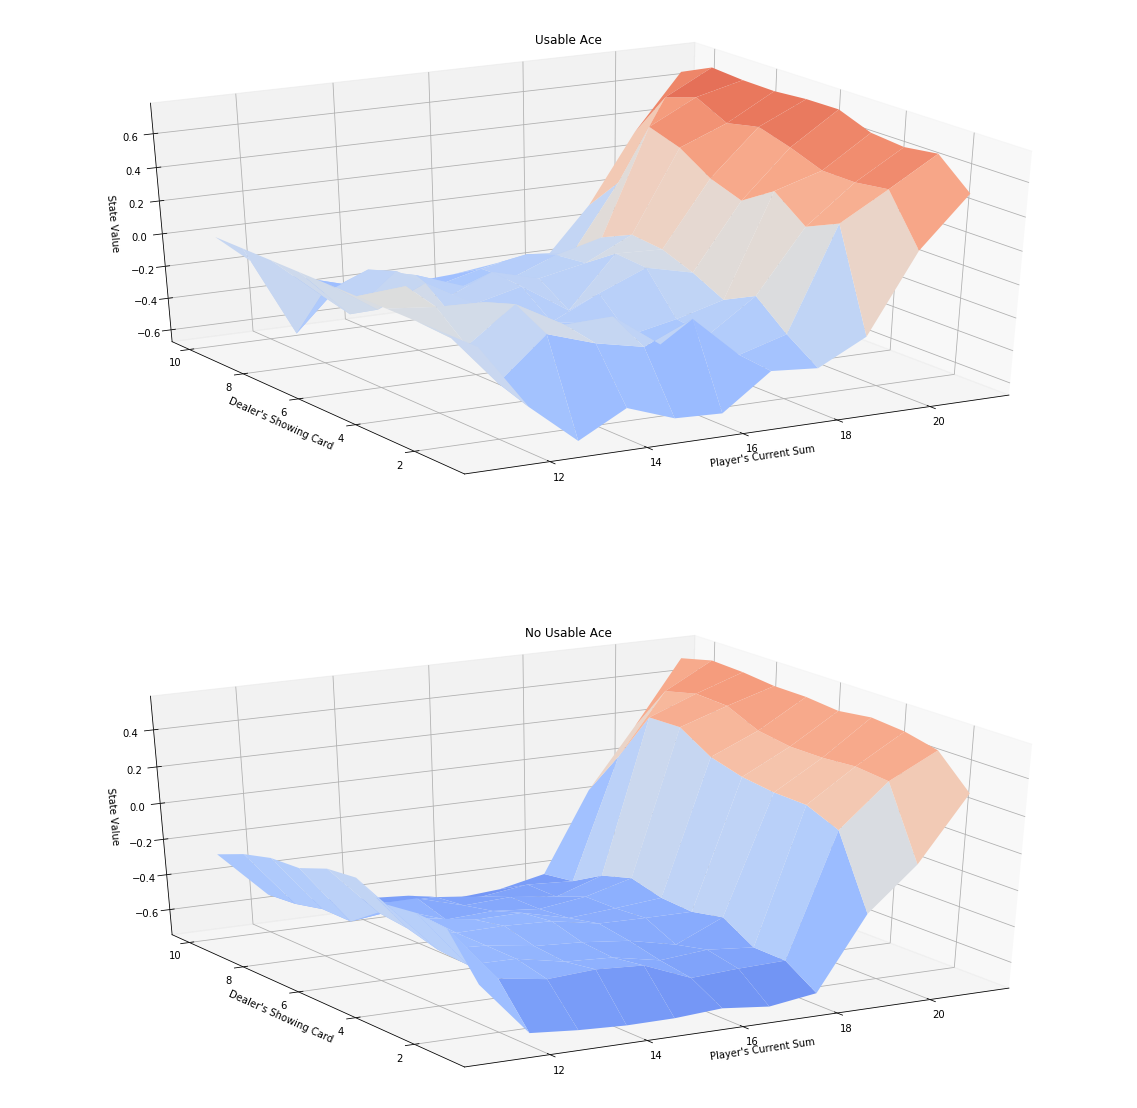

In [41]:
#obtain the corresponding state-value fucntion
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

#plot the state-value function
plot_blackjack_values(V_to_plot)


### Part 2 : Monte-Carlo Control